Import libraries

In [69]:
#! pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch


     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 133kB 7.8MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp36-none-any.whl size=38932 sha256=252f3ca38fa37c74342bb92f2eb6c1876ed002cda5f854efe85219191c7cb547
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
Successfully built python-hostlist


In [ ]:
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

Import data and select the features to be inputted into the LSTM model

In [75]:
#Import Data
daily_url = 'https://raw.githubusercontent.com/cybertraining-dsc/fa20-523-313/main/dailydf.csv'
StopWatch.start("import data")
daily_df = pd.read_csv(daily_url)
StopWatch.stop("import data")
StopWatch.status("import data", True)
#Select the features to be inputted into the LSTM model
cols = list(daily_df)[2:10]





In [35]:
daily_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,macd,macdsignal,macdhist
0,68,4/18/2000,530.062012,536.622009,525.768982,528.258972,3961700,-27.483774,-30.106387,2.622614
1,69,4/19/2000,528.206970,530.961975,524.807983,526.299988,4194800,-28.220101,-29.907831,1.687730
2,70,4/20/2000,526.299988,526.395996,519.213013,526.395996,2201000,-28.782709,-29.789397,1.006688
3,71,4/24/2000,526.078979,530.848999,524.443970,530.848999,1693500,-29.005682,-29.706901,0.701218
4,72,4/25/2000,529.731018,529.731018,515.619995,519.043030,2908500,-29.614482,-29.697172,0.082690


In [77]:
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df.index = daily_df['Date']
slice_df = pd.to_datetime("2015-01-01")
daily_df = daily_df.loc[slice_df:]
daily_df.shape

(1428, 10)

Split the train and test data, and extract the dates for indexing in the plot visualization

In [78]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(daily_df, train_size=0.80, test_size = 0.20, shuffle = False)

# Extract dates of training data
datelist_train = list(dataset_train['Date'])
#datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Extract dates of testing data
datelist_test = list(dataset_test['Date'])
#datelist_test = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_test]

dataset_train = dataset_train[cols].astype(str)
dataset_train = dataset_train.astype(float)

dataset_test = dataset_test[cols].astype(str)
dataset_test = dataset_test.astype(float)

training_set = dataset_train.values
testing_set = dataset_test.values

print('Shape of training set == {}.'.format(training_set.shape))
print('Selected features: {}'.format(cols))

Shape of training set == (1142, 8).
Selected features: ['Open', 'High', 'Low', 'Close', 'Volume', 'macd', 'macdsignal', 'macdhist']


Scaling the features before inputted into the LSTM model

In [79]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

#sc_predict = StandardScaler()
#sc_predict.fit_transform(training_set[:, 0:1])


Selecting the time step windows.

In [80]:
StopWatch.start("Creating the train and test data")
X_train = []
y_train = []

x_test = []
y_test = []

n_future = 1   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):    
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

for i in range(n_past, len(testing_set_scaled) - n_future +1):    
    x_test.append(testing_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_test.append(testing_set_scaled[i + n_future - 1:i + n_future, 0])
#X_train takes the Open, High, Low, and Close, to predict y_train which is the Open price for 60 days after
X_train, y_train = np.array(X_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

StopWatch.stop("Creating the train and test data")
StopWatch.status("Creating the train and test data", True)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

print('x_test shape == {}.'.format(x_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (1052, 90, 8).
y_train shape == (1052, 1).
x_test shape == (196, 90, 8).
y_test shape == (196, 1).


LSTM Model

In [81]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [82]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
#model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

Training

In [83]:
StopWatch.start("Train the model")
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256) #
StopWatch.stop("Train the model")
StopWatch.status("Train the model", True)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.3269
Epoch 00001: val_loss improved from inf to 0.05986, saving model to weights.h5
4/4 [==============================] - 2s 483ms/step - loss: 0.3269 - val_loss: 0.0599
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.0946
Epoch 00002: val_loss did not improve from 0.05986
4/4 [==============================] - 1s 162ms/step - loss: 0.0946 - val_loss: 0.0757
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.0757
Epoch 00003: val_loss improved from 0.05986 to 0.02242, saving model to weights.h5
4/4 [==============================] - 1s 163ms/step - loss: 0.0757 - val_loss: 0.0224
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.0609
Epoch 00004: val_loss did not improve from 0.02242
4/4 [==============================] - 1s 167ms/step - loss: 0.0609 - val_loss: 0.0681
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 0.0557
Epoch 00005: val_l

<Figure size 1008x360 with 0 Axes>

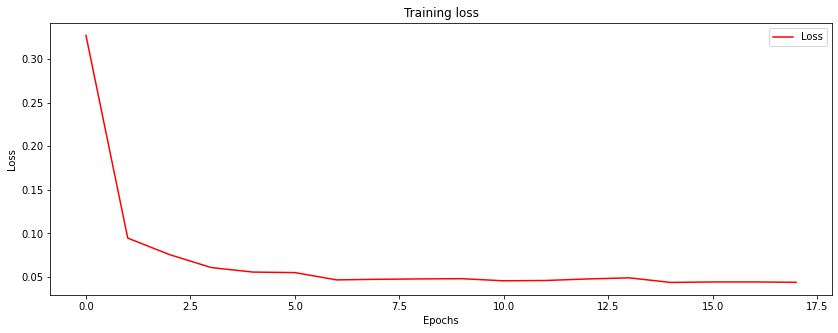

<Figure size 1008x360 with 0 Axes>

In [84]:
epochloss=history.history['loss']
epochs=range(len(epochloss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, epochloss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


Make Prediction

In [85]:
StopWatch.start("Predict data")
predictions_train = model.predict(X_train[n_past:])
predictions_test = model.predict(x_test[n_past:])

StopWatch.stop("Predict data")
StopWatch.status("Predict data", True)

Revert the scaled data to the original scale, and prepare the data for plotting visualization



In [86]:

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%m/%d/%Y'), '%m/%d/%Y')

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

y_pred_train = sc_predict.inverse_transform(predictions_train)
y_pred_test = sc_predict.inverse_transform(predictions_test)

PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
PREDICTION_TEST = pd.DataFrame(y_pred_test, columns=['Open']).set_index(pd.Series(datelist_test[2 * n_past + n_future -1:]))


PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
PREDICTION_TEST.index = PREDICTION_TEST.index.to_series().apply(datetime_to_timestamp)

dataset_train.index = datelist_train
dataset_test.index = datelist_test

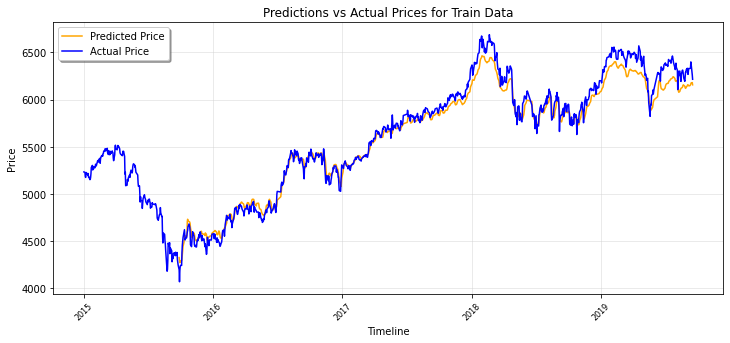

In [87]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

START_DATE_FOR_PLOTTING = pd.to_datetime("2010-01-04") 

plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Predicted Price')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Price')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions vs Actual Prices for Train Data', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Price', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [88]:
import math
import statistics
rmse = np.sqrt(np.mean(np.power((PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'] - dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open']),2)))
print(rmse)

96.29776042252264


In [89]:
np.std(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'])

557.667236328125

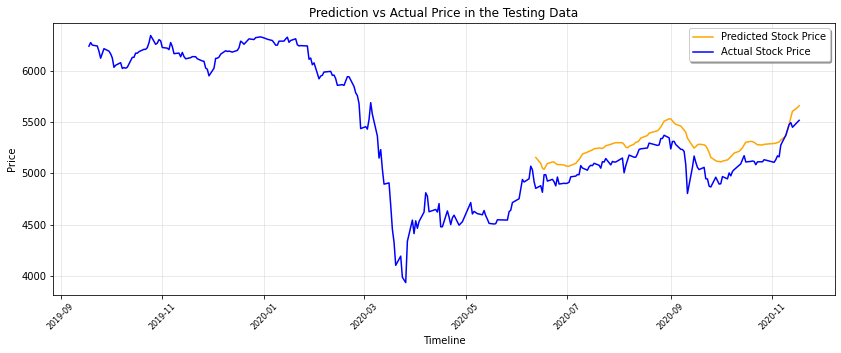

In [90]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

START_DATE_FOR_PLOTTING = pd.to_datetime("2017-01-01")

plt.plot(PREDICTION_TEST.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TEST.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Predicted Stock Price')
plt.plot(dataset_test.loc[START_DATE_FOR_PLOTTING:].index, dataset_test.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediction vs Actual Price in the Testing Data', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Price', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [91]:
rmse = np.sqrt(np.mean(np.power((PREDICTION_TEST.loc[START_DATE_FOR_PLOTTING:]['Open'] - dataset_test.loc[START_DATE_FOR_PLOTTING:]['Open']),2)))
print(rmse)

181.5351674252924


In [ ]:
rmse_data = [237.27992208443038, 583.0930105074565]

In [92]:
StopWatch.benchmark()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           